In [1]:
#Απαραίτητες βιβλιοθήκες,gpu support και αρχικοποίηση random seed
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

# === GPU / CPU support ===
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
except:
    device = torch.device("cpu")
print(f"Using device: {device}")

# === Random seed ===
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

Using device: cuda


In [2]:
#Text cleaning και slang replacement
lemmatizer = WordNetLemmatizer()

def cleaning(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    slang_dict = {
        r'\bur\b': 'your', r'\bu\b': 'you', r'\br\b': 'are',
        r'\bbrb\b': 'be right back', r'\bbtw\b': 'by the way',
        r'\blol\b': 'laughing out loud', r'\bomg\b': 'oh my god',
        r'\btmr\b': 'tomorrow', r'\bppl\b': 'people',
        r'\bidk\b': 'i do not know', r'\bimo\b': 'in my opinion',
        r'\bimho\b': 'in my humble opinion', r'\bwanna\b': 'want to',
        r'\bgonna\b': 'going to', r'\bgotta\b': 'got to',
        r'\bcuz\b': 'because', r'\bcoz\b': 'because', r'\bnvm\b': 'nevermind',
        r'\bya\b': 'yes', r'\byeah\b': 'yes', r'\blmk\b': 'let me know',
        r'\bttyl\b': 'talk to you later'
    }
    for k, v in slang_dict.items():
        text = re.sub(k, v, text)

    text = re.sub(r"\bi['’]?m\b", "i am", text)
    text = re.sub(r"\bdon['’]?t\b", "do not", text)
    text = re.sub(r"\bdoesn['’]?t\b", "does not", text)
    text = re.sub(r"\bhaven['’]?t\b", "have not", text)
    text = re.sub(r"\bhasn['’]?t\b", "has not", text)
    text = re.sub(r"\bcan['’]?t\b", "can not", text)
    text = re.sub(r"\bur\b", "you are", text)
    text = re.sub(r"\bure\b", "you are", text)

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [3]:
#Load and clean data
train_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/train_dataset.csv")
val_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/val_dataset.csv")
test_df = pd.read_csv("/kaggle/input/ai-2-dl-for-nlp-2025-homework-2/test_dataset.csv")

train_df['Text'] = train_df['Text'].apply(cleaning)
val_df['Text'] = val_df['Text'].apply(cleaning)
test_df['Text'] = test_df['Text'].apply(cleaning)

train_sentences = [text.split() for text in train_df["Text"]]
val_sentences = [text.split() for text in val_df["Text"]]
test_sentences = [text.split() for text in test_df["Text"]]

y_train = train_df["Label"].values
y_val = val_df["Label"].values

In [4]:
#Train Word2Vec Model
best_params = {'vector_size': 200, 'window': 5, 'min_count': 1, 'negative': 5}
best_w2v_model = Word2Vec(
    sentences=train_sentences + val_sentences,
    vector_size=best_params['vector_size'],
    window=best_params['window'],
    min_count=best_params['min_count'],
    negative=best_params['negative'],
    sg=1, workers=1, seed=SEED
)


In [5]:
#Convert Sentences to Embeddings
def sentence_to_vector(sentence, model, dim):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_train = np.array([sentence_to_vector(s, best_w2v_model, dim=200) for s in train_sentences])
X_val = np.array([sentence_to_vector(s, best_w2v_model, dim=200) for s in val_sentences])
X_test = np.array([sentence_to_vector(s, best_w2v_model, dim=200) for s in test_sentences])

In [6]:
#PyTorch Dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=256, shuffle=True)
val_loader = DataLoader(SentimentDataset(X_val, y_val), batch_size=256)

In [7]:
#Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=200, hidden_dim=512, output_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(hidden_dim // 4, output_dim)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.dropout3(self.relu3(self.fc3(x)))
        return self.fc4(x)

model = SentimentClassifier(input_dim=200).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
def objective(trial):
    hidden_dim = trial.suggest_categorical("hidden_dim", [128, 256, 512, 768])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # DataLoaders
    train_loader = DataLoader(SentimentDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(SentimentDataset(X_val, y_val), batch_size=batch_size)

    class TrialModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(200, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim // 2, hidden_dim // 4),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(hidden_dim // 4, 2)
            )

        def forward(self, x):
            return self.net(x)

    model = TrialModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    for epoch in range(10):  # μικρός αριθμός epochs για tuning
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # validation
        model.eval()
        val_preds = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                pred = torch.argmax(output, dim=1)
                val_preds.extend(pred.cpu().numpy())

        val_acc = accuracy_score(y_val, val_preds)
        best_val_acc = max(best_val_acc, val_acc)

    return best_val_acc

In [9]:
#Training loop and early stopping
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []
EPOCHS = 10
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(out, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_preds = []
    val_loss_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            val_loss_total += loss.item()
            _, pred = torch.max(out, 1)
            val_preds.extend(pred.cpu().numpy())

    val_acc = accuracy_score(y_val, val_preds)
    val_accuracies.append(val_acc)
    avg_val_loss = val_loss_total / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(best_model_state)

Epoch 1: Train Acc = 0.7351, Val Acc = 0.7602, Val Loss = 0.4897
Epoch 2: Train Acc = 0.7539, Val Acc = 0.7658, Val Loss = 0.4823
Epoch 3: Train Acc = 0.7575, Val Acc = 0.7672, Val Loss = 0.4790
Epoch 4: Train Acc = 0.7601, Val Acc = 0.7677, Val Loss = 0.4769
Epoch 5: Train Acc = 0.7622, Val Acc = 0.7705, Val Loss = 0.4739
Epoch 6: Train Acc = 0.7640, Val Acc = 0.7705, Val Loss = 0.4744
Epoch 7: Train Acc = 0.7660, Val Acc = 0.7648, Val Loss = 0.4830
Epoch 8: Train Acc = 0.7668, Val Acc = 0.7692, Val Loss = 0.4759
Epoch 9: Train Acc = 0.7686, Val Acc = 0.7683, Val Loss = 0.4749
Epoch 10: Train Acc = 0.7698, Val Acc = 0.7720, Val Loss = 0.4719


<All keys matched successfully>

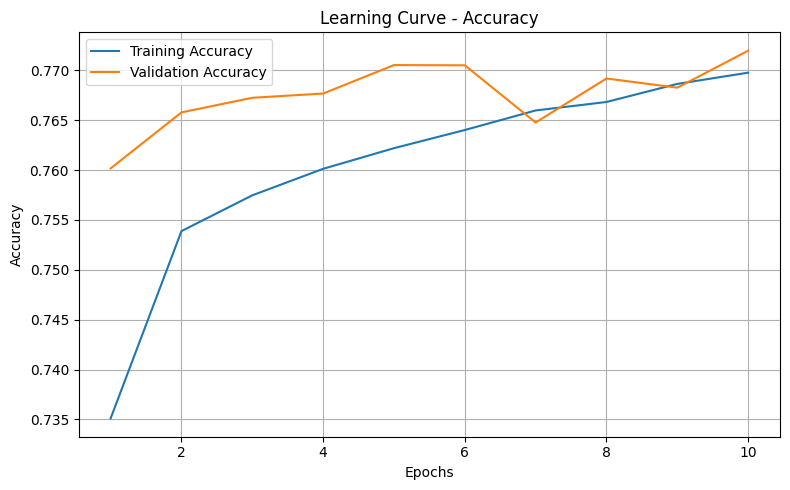

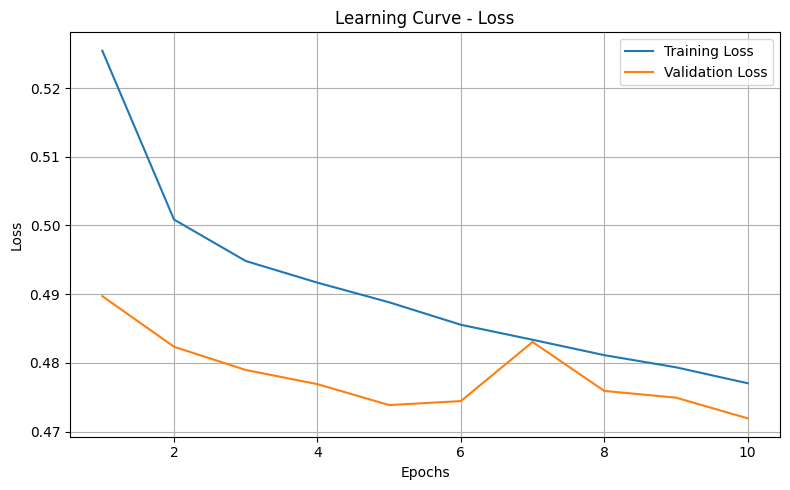

In [10]:
# Learning curves

# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_accuracy.png")
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve - Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("learning_curve_loss.png")
plt.show()


In [11]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best hyperparameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-05-05 17:38:21,715] A new study created in memory with name: no-name-2ac02716-b8d4-4609-882b-1d3ede0f9f8b
[I 2025-05-05 17:38:53,291] Trial 0 finished with value: 0.7584441928483819 and parameters: {'hidden_dim': 256, 'dropout_rate': 0.3733301603594552, 'lr': 0.006572955652217224, 'weight_decay': 0.0007659265649785872, 'batch_size': 128}. Best is trial 0 with value: 0.7584441928483819.
[I 2025-05-05 17:39:25,232] Trial 1 finished with value: 0.7606377960184924 and parameters: {'hidden_dim': 512, 'dropout_rate': 0.15929548055531673, 'lr': 0.009420641223807355, 'weight_decay': 6.976413783262092e-05, 'batch_size': 128}. Best is trial 1 with value: 0.7606377960184924.
[I 2025-05-05 17:39:47,923] Trial 2 finished with value: 0.7702141711482215 and parameters: {'hidden_dim': 256, 'dropout_rate': 0.1761240489087934, 'lr': 0.0029688435522890145, 'weight_decay': 4.526802972237002e-05, 'batch_size': 256}. Best is trial 2 with value: 0.7702141711482215.
[I 2025-05-05 17:40:41,535] Trial 3

Best trial:
  Accuracy: 0.7777148787621474
  Best hyperparameters:
    hidden_dim: 768
    dropout_rate: 0.21558810951539148
    lr: 0.00027422081792460276
    weight_decay: 2.0965984009547323e-05
    batch_size: 256


              precision    recall  f1-score   support

    Negative       0.75      0.82      0.78     21197
    Positive       0.80      0.72      0.76     21199

    accuracy                           0.77     42396
   macro avg       0.77      0.77      0.77     42396
weighted avg       0.77      0.77      0.77     42396



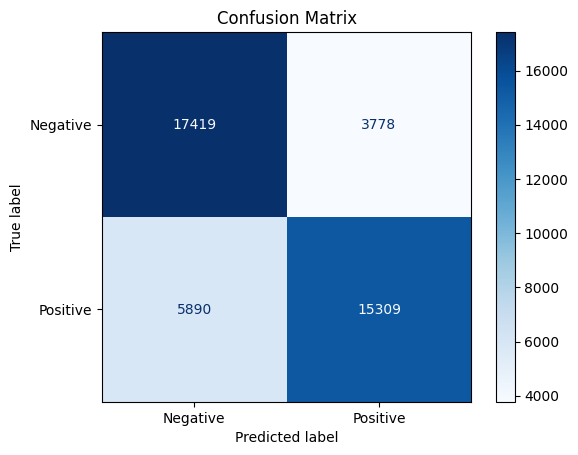

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predictions στο validation set
model.eval()
val_preds_final = []
val_true = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        output = model(xb)
        pred = torch.argmax(output, dim=1)
        val_preds_final.extend(pred.cpu().numpy())
        val_true.extend(yb.numpy())

# Classification Report
print(classification_report(val_true, val_preds_final, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(val_true, val_preds_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

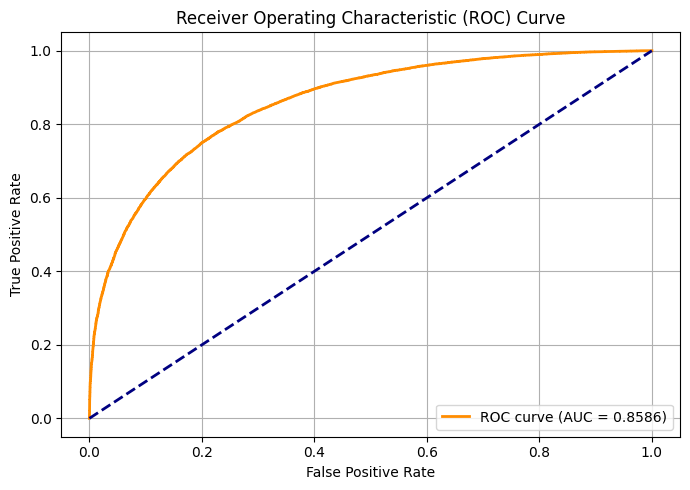

In [13]:
# ROC curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels (για ROC Curve – 2 classes: 0 και 1)
y_val_bin = label_binarize(y_val, classes=[0, 1]).ravel()

# Get predicted probabilities για class 1
model.eval()
y_probs = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        output = model(xb)
        prob = torch.softmax(output, dim=1)[:, 1]  # Probabilities for class 1
        y_probs.extend(prob.cpu().numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val_bin, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()